In [ ]:
'''
Bhavesh Uppaluri
B.Tech. CSE (3yr) Bennett University
ubhavesh2908@gmail.com
'''

In [1]:
# HOW TO USE REPO
# download zip and extract assignment.ipynb file and dataset50 folder
# create a folder containing dataset folder (named dataset50) and an empty forecast images folder (named forecasts)
# give this path to ASSIGNMENT_PATH variable in the ipynb file
# the code will automatically read from the dataset folder and store forecast plots to the forecasts folder
# at the end of the complete execution, it will also store all the error metrics of the timeseries' in the dataset, in a csv file named metrics.csv which can be found in the main folder

# ASSUMPTIONS
# given timeseries has hourly frequency 
# given timeseries is only for 35 days, i.e. has exactly 840 samples

# ISSUES [AND SOLUTIONS]
# hyperparameters are tuned manually [NEED TO IMPLEMENT CUSTOM CLASS FOR HYPER-PARAMETER TUNING]
# interpretable NBeats model which may detect seasonality and trend when there is none (0 or constant values) [USING ENSEMBLE TECHNIQUES WITH GENERIC MODELS MAY SOLVE THE PROBLEM] 

In [2]:
# clone RevIN repository in C:\Users\*user-name* folder
!git clone https://github.com/ts-kim/RevIN.git

fatal: destination path 'RevIN' already exists and is not an empty directory.


In [3]:
# install darts module
!pip install darts

In [4]:
# import required modules
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pylab import rcParams
import statsmodels.api as sm
from RevIN.RevIN import RevIN 
import torch
import darts
from darts import TimeSeries 
from darts.models import NBEATSModel
from darts.metrics import mae,mape,mse,rmse
from sklearn.model_selection import TimeSeriesSplit,RandomizedSearchCV



In [5]:
ASSIGNMENT_PATH='C:/Users/bhave/Desktop/MLREassignment/'
DATASET_PATH=ASSIGNMENT_PATH+'dataset50/'

In [6]:
# Read '6' timeseries data and store as pandas dataframe
# csv has three columns: index, value, timestamp
data = pd.read_csv(DATASET_PATH+'6.csv',index_col=0)
data.head()

value   timestamp
0  986.3964  1595323800
1  931.5982  1595327400
2  906.8550  1595331000
3  924.9362  1595334600
4  898.0307  1595338200

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 838 entries, 0 to 837
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   value      838 non-null    float64
 1   timestamp  838 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 19.6 KB


In [8]:
# function to preprocess given dataframe into usable consistent timeseries
def preprocess(data,frequency= "1H"):
    # convert timestamp column to datetime format and set datetime column as index

    data['timestamp'] = pd.to_datetime(data['timestamp'],unit='s')
    # rename timestamp column to datetime
    data.rename(columns={'timestamp':'datetime'},inplace=True)
    # sort data according to datetime column
    data.sort_values(by='datetime')
    # set datetime column as index 
    data=data.set_index('datetime')    
    
    # resize timeseries with fixed frequency (assumed hourly) and fill values using nearest strategy
    
    # resampling series to hourly frequency filling missing values with NaN
    data=data.resample('1H',origin='start').asfreq()    
    # filling NaN values with nearest strategy
    data=data.interpolate('nearest')
    # convenience code for fixing size of timeseries missed by resample and interpolate in some cases
    if len(data)==839:
        time=datetime.strptime('2020-08-25 08:30:00','%Y-%m-%d %H:%M:%S')
        temp=pd.DataFrame(data={'datetime':[time],'value':[data.iloc[-1].value]}).set_index('datetime')#,index='datetime')
        data=pd.concat([data, temp])
    
    return data

data=preprocess(data)

data.head()

value
datetime                     
2020-07-21 09:30:00  986.3964
2020-07-21 10:30:00  931.5982
2020-07-21 11:30:00  906.8550
2020-07-21 12:30:00  924.9362
2020-07-21 13:30:00  898.0307

In [9]:
data.describe()

value
count  8.400000e+02
mean   3.859543e+09
std    2.052284e+10
min    2.533407e+02
25%    7.060190e+02
50%    9.582683e+02
75%    1.081721e+03
max    4.888387e+11

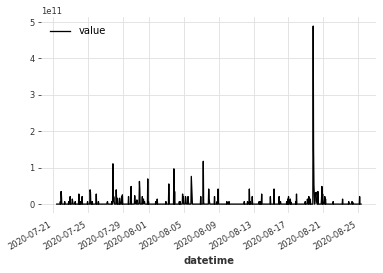

In [10]:
# plotting timeseries
data.plot()
plt.show()

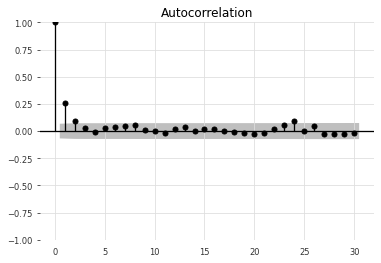

In [11]:
# plot acf graph to study correlation coefficients between series and lags of itself
plot_acf(data);


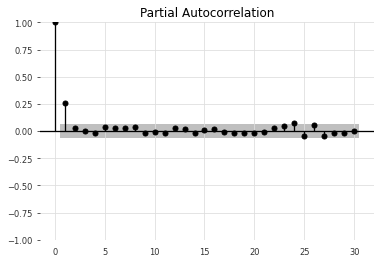

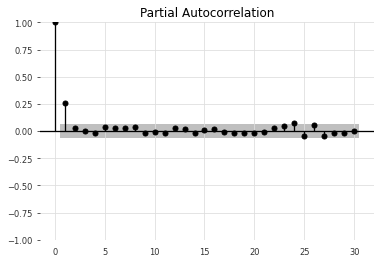

In [12]:
# plot pacf graph to study partial correlation coefficients between the series and lags of itself
plot_pacf(data,method='ywm')

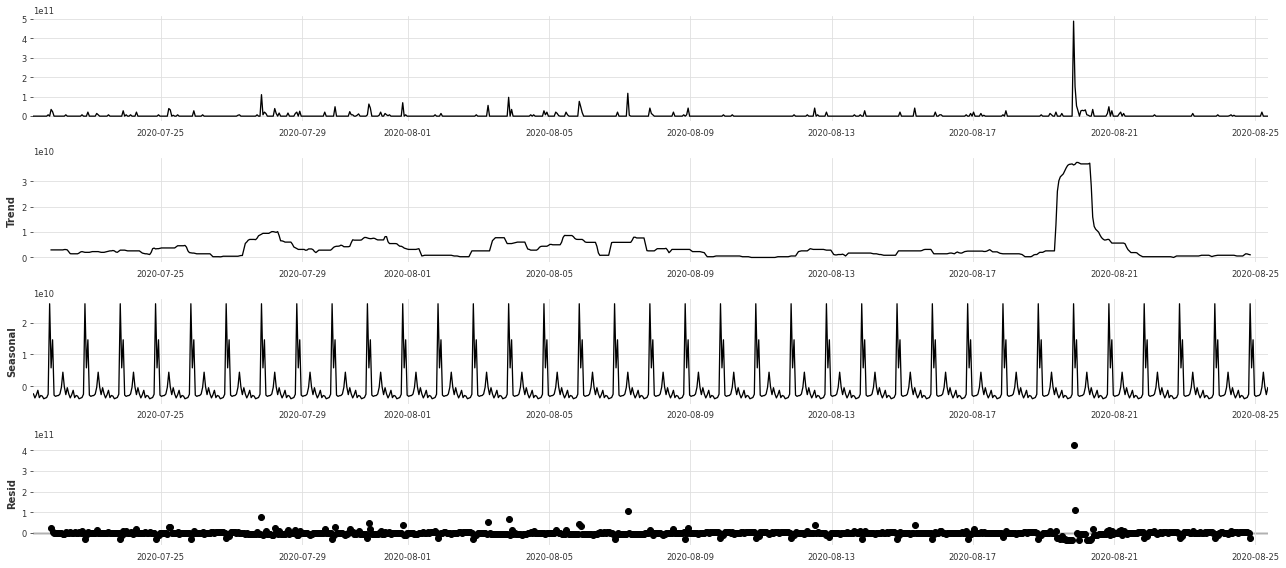

In [13]:
# plot of seasonal decomposition using moving averages
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data)
fig = decomposition.plot()
plt.show()

In [14]:
# datatype conversion functions

def dataframe_to_tensor(df,column_name):
    # convert the given dataframe column to torch tensor
    import torch
    return torch.tensor(df[column_name].values)

def tensor_to_timeseries(t,date_series):
    # convert tensor to dataframe to timeseries
    from darts import TimeSeries
    return TimeSeries.from_dataframe(pd.DataFrame(data=t.detach().numpy(),index=date_series))#,fill_missing_dates=True, freq='1H') 

def timeseries_to_tensor(ts):
    # convert timeseries to dataframe to tensor
    df=ts.pd_dataframe()
    return torch.tensor(df['0'].values),df.index.values


In [15]:
# function to revin normalize given dataframe after converting to tensor 
# and then returning a timeseries converted using the tensor
def norm(df,column_name):
    from RevIN.RevIN import RevIN
    import torch
    revin_layer = RevIN(num_features=1)
    t = dataframe_to_tensor(df=df,column_name=column_name)
    t_norm = revin_layer(t, 'norm')
    return tensor_to_timeseries(t_norm,df.index.values),revin_layer

# implementation of revin normalization layer
# as this official implementation only takes tensor input we cannot integrate revin as a layer in the NBeats model implemented below
x,revin_layer = norm(data,column_name='value')

In [16]:
# Split data into training and testing datasets.
num_samples=data.shape[0]
train_size = int(num_samples*0.75)
x_train, x_test = x[:train_size], x[train_size:]

test_size = len(x_test)

In [17]:
# parameters grid for nbeats model tuning using randomized search cv 
width_set = [32,64,128,256,512]
parameters = {
    'input_chunk_length': [24], # length of the input sequence fed to the model.
    'output_chunk_length': [6],#,48,72,168], # length of the forecast of the model.
    'generic_architecture': [True,False], #If false, the interpretable architecture outlined in the paper 
    'num_stacks': [1,3,5,10], #g# number of stacks that make up the whole model. Only used if generic_architecture is set to True
    'num_blocks': [1,2,3], # number of blocks making up every stack.
    'num_layers': [4,5,6], #g# number of fc layers preceding the final forking layers in each block of every stack. Only used if generic_architecture is set to True.
    'layer_widths': width_set+[[i,j] for i in width_set for j in width_set], 
    'expansion_coefficient_dim': [2,3,32], #g# dimensionality of the waveform generator parameters, also known as expansion coefficients. Only used if generic_architecture is set to True.
    'trend_polynomial_degree': [1,2,3,4,5], #ts# degree of the polynomial used as waveform generator in trend stacks. Only used if generic_architecture is set to False.
    'dropout': [0.5,0.6,0.7,0.8,0.9,1.0], # 0-1 
    'activation': ['ReLU','RReLU','PReLU','Softplus','Tanh','SELU','LeakyReLU','Sigmoid'],
    'loss_fn': [torch.nn.MSELoss()],
    'batch_size': [32,64,128],
    'n_epochs': [5],
    'force_reset': [True]
}

In [18]:
# cannot implement sklearn function for randomized search cv without making convenience child class to implement sklearn functions for darts nbeats model
#m=RandomizedSearchCV(model,parameters,n_iter=100,scoring='neg_mean_squared_error',cv=cv).fit(x_train)

In [19]:
tsize,vsize=48,24 #backcast length and forecast horizon ##rough#train_size+1,test_size+1
#train_index, val_index = list(range(tsize+1)),list(range(tsize+1,tsize+vsize+1))#indices

# build NBeats model

# in-built gridsearchcv function (even if implemented as RandomizedSearchCV) is not completely implemented and gives a lot of errors which would take ages to handle
# therefore model is built using specifications of interpretable model suggested in the paper

m=NBEATSModel(tsize,vsize)#.gridsearch(parameters, x_train[x_train.time_index[train_index]], val_series=x_train[x_train.time_index[val_index]], n_jobs=-1, n_random_samples=15)

In [20]:
# fit model on training data
m.fit(x_train)

2022-06-26 21:14:53 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 559 samples.
2022-06-26 21:14:53 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
2022-06-26 21:14:53 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-06-26 21:14:53 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-26 21:14:53 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-26 21:14:53 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-06-26 21:14:53 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.4 M 
--

Training: 0it [00:00, ?it/s]

In [22]:
# predict data for the next test_size points
p = m.predict(n=test_size,series=x_train)

Predicting: 18it [00:00, ?it/s]

In [23]:
# revin denormalization function
# takes timeseries and revin object and denormalizes converted tensor and returns converted timeseries 
def denorm(ts,revin_func):
    tensor,date_series = timeseries_to_tensor(ts)
    denorm_tensor=revin_func(tensor,'denorm')
    return tensor_to_timeseries(denorm_tensor,date_series)

In [24]:
finalp = denorm(p,revin_layer)
finalx_test = denorm(x_test,revin_layer)
finalx_train = denorm(x_train,revin_layer)

In [25]:
# functions for metrics

# function to calculate metrics, takes actual and predicted values in TimeSeries datatype
def get_metrics(act,pred):
    from darts.metrics import mae,mape,mse,rmse
    d = {'mae':mae(act,pred),'mse':mse(act,pred),'rmse':rmse(act,pred)}
    try:
        d['mape']=mape(act,pred)
    except:
        d['mape']=pd.NA
    return d

# function to print metrics
def print_metrics(act,pred,decimal_places=6):
    m=get_metrics(act,pred)
    s=str('{:.'+str(decimal_places)+'f}')
    print(str('MAE='+s+'\nMSE='+s+'\nRMSE='+s+'\nMAPE='+s+'%').format(m['mae'],m['mse'],m['rmse'],m['mape']))

In [26]:
# function to plot predicted forecast along with original timeseries
def plot_forecast(x_train,x_test,p):
    fig = plt.figure()
    x_train.plot(color='b',label='actual train')
    x_test.plot(color='b',linestyle='dotted',label='actual test')
    p.plot(color='m',label='forecast')
    plt.legend()
    return fig
    

MAE=8896167342.184654
MSE=1346675505204199686144.000000
RMSE=36697077611.224030
MAPE=420156803.169254%


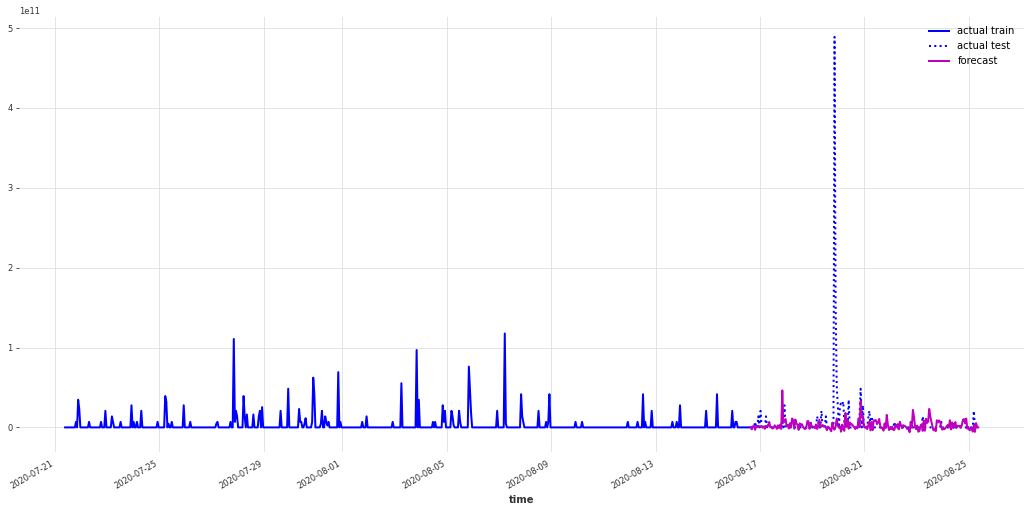

In [27]:
print_metrics(finalx_test,finalp)
fig=plot_forecast(finalx_train,finalx_test,finalp)

In [ ]:
## below is loop for doing above process for all the timeseries given in dataset

2022-06-26 21:42:17 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 560 samples.
2022-06-26 21:42:17 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
2022-06-26 21:42:17 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-06-26 21:42:17 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-26 21:42:17 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-26 21:42:17 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-06-26 21:46:14 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 560 samples.
2022-06-26 21:46:14 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
2022-06-26 21:46:14 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-06-26 

2022-06-26 22:30:55 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-26 22:30:55 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-26 22:30:55 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-06-26 22:34:59 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 560 samples.
2022-06-26 22:34:59 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
2022-06-26 22:34:59 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-06-26 22:34:59 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-26 22:34:59 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-26 22:34:59 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-06-26 22:39:05 darts.models.forecasting.tor

2022-06-26 23:22:59 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-26 23:22:59 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-06-26 23:27:11 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 560 samples.
2022-06-26 23:27:11 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
2022-06-26 23:27:11 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-06-26 23:27:11 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-26 23:27:11 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-26 23:27:11 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-06-26 23:31:30 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 560 samples.
2022-06-26 23:31:30 darts.models.forecasti

2022-06-27 00:20:58 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-06-27 00:20:58 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-27 00:20:58 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-27 00:20:58 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-06-27 00:25:27 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 560 samples.
2022-06-27 00:25:27 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
2022-06-27 00:25:27 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-06-27 00:25:27 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-27 00:25:27 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-27 00:25:27 pytorch_lightning.utilities.ra

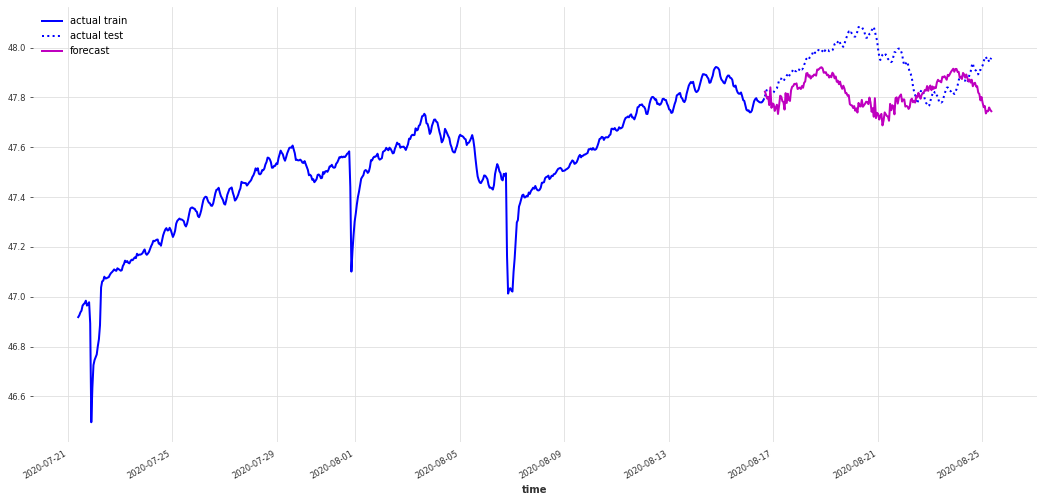

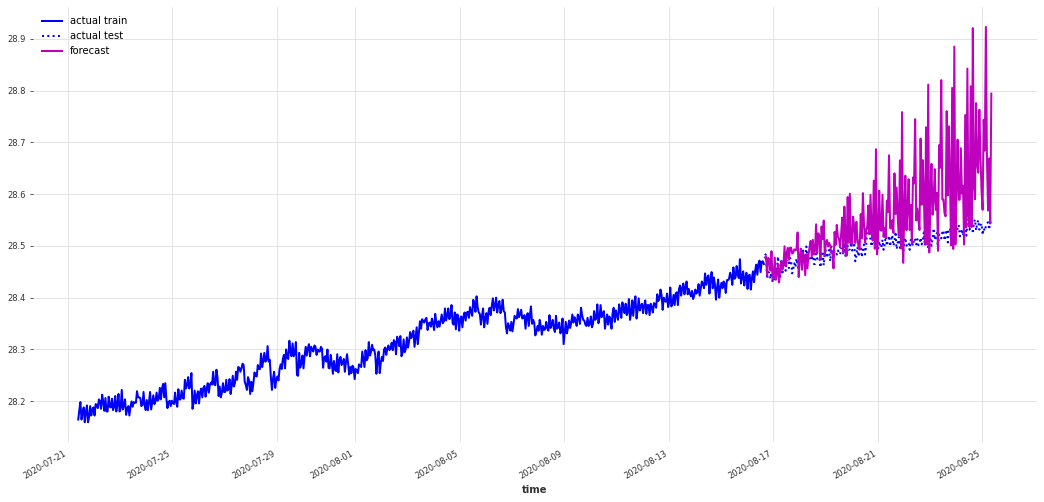

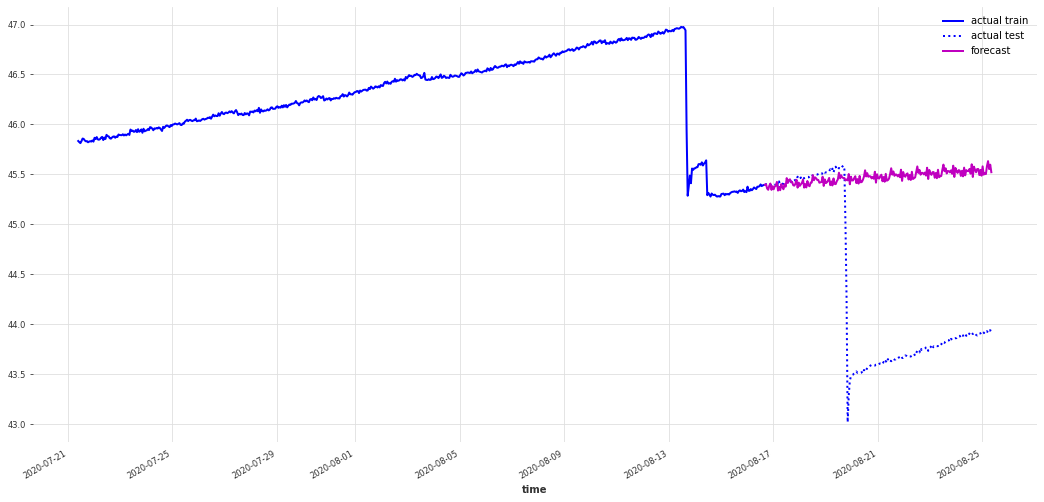

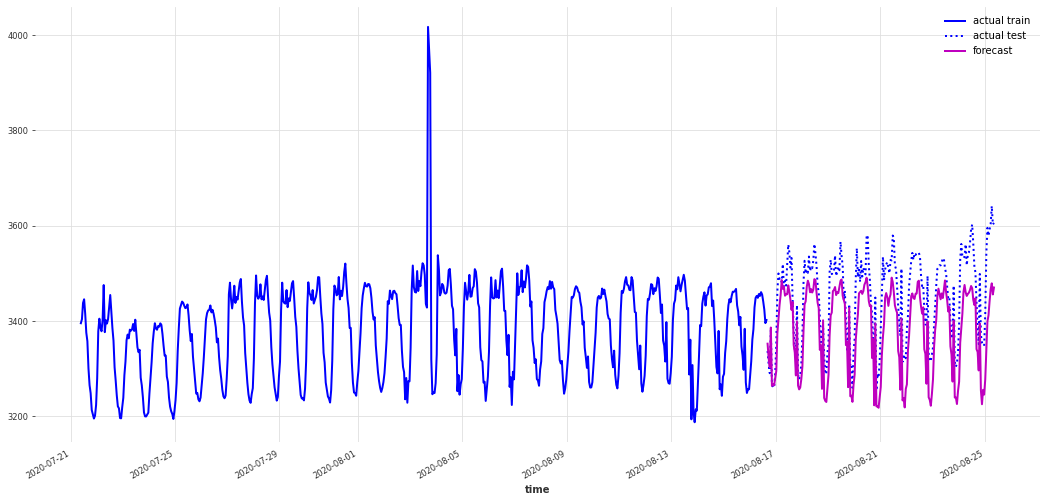

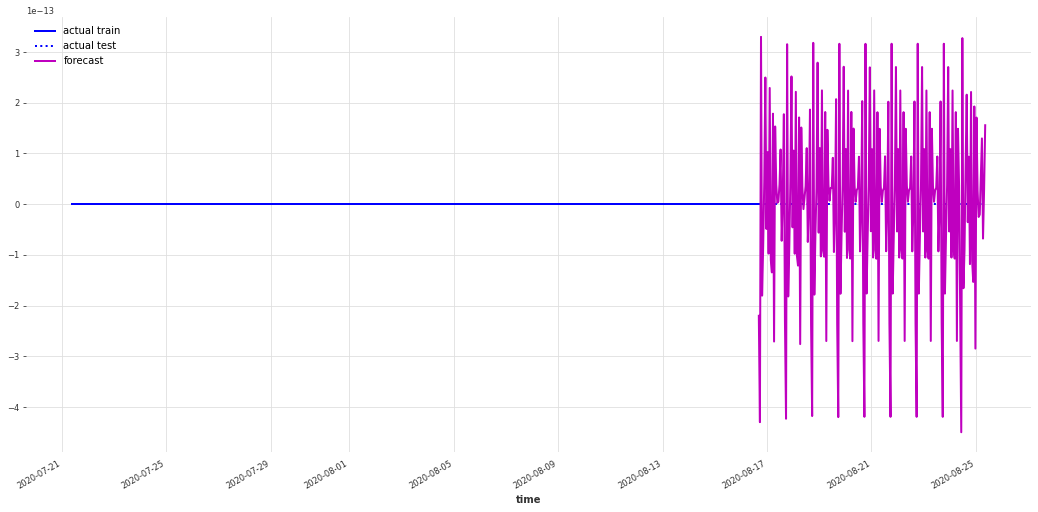

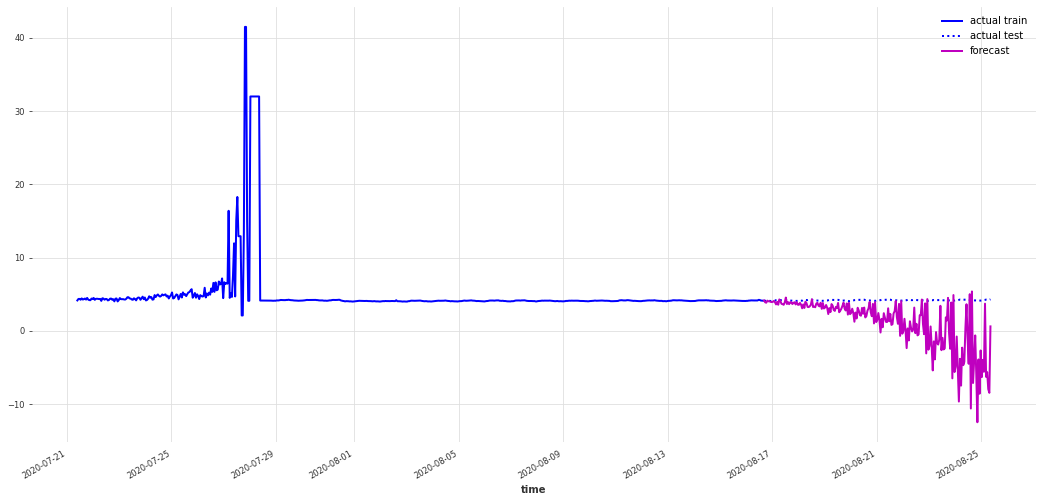

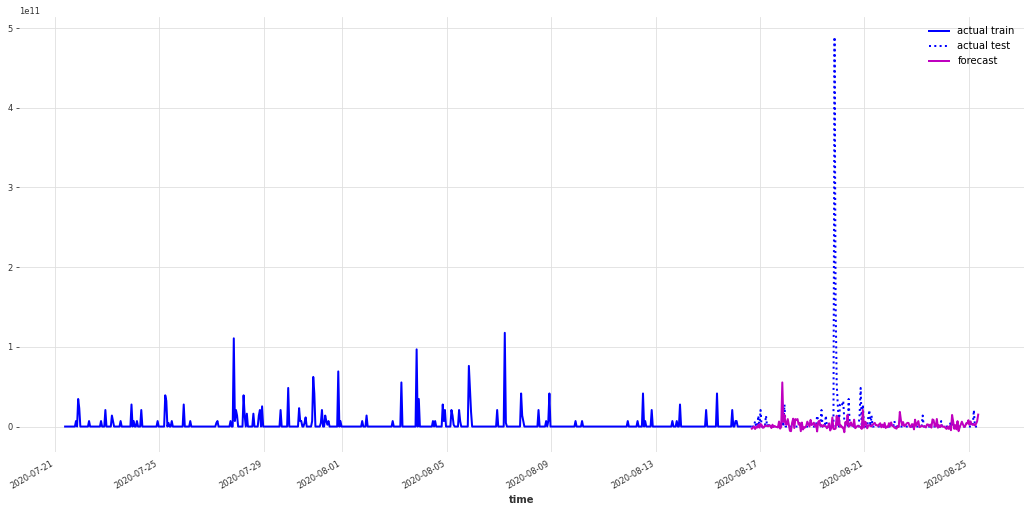

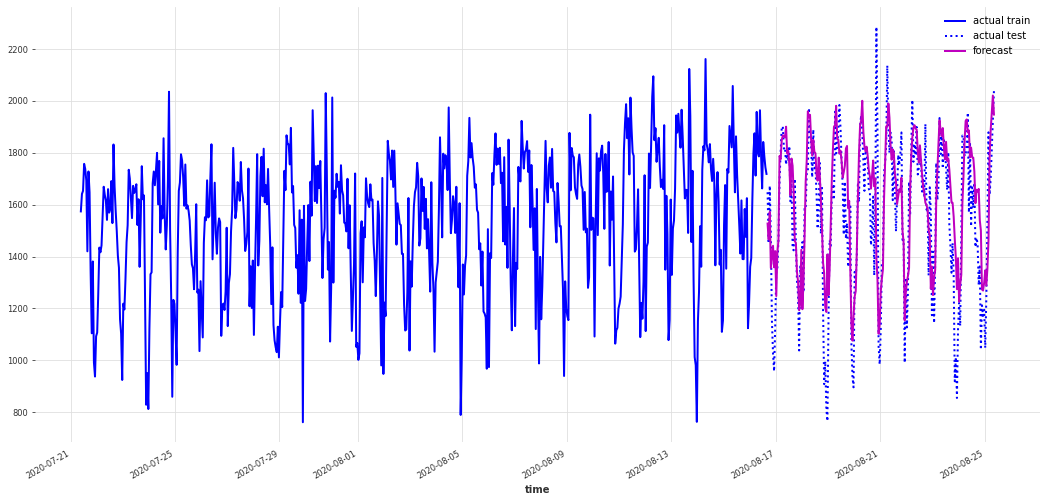

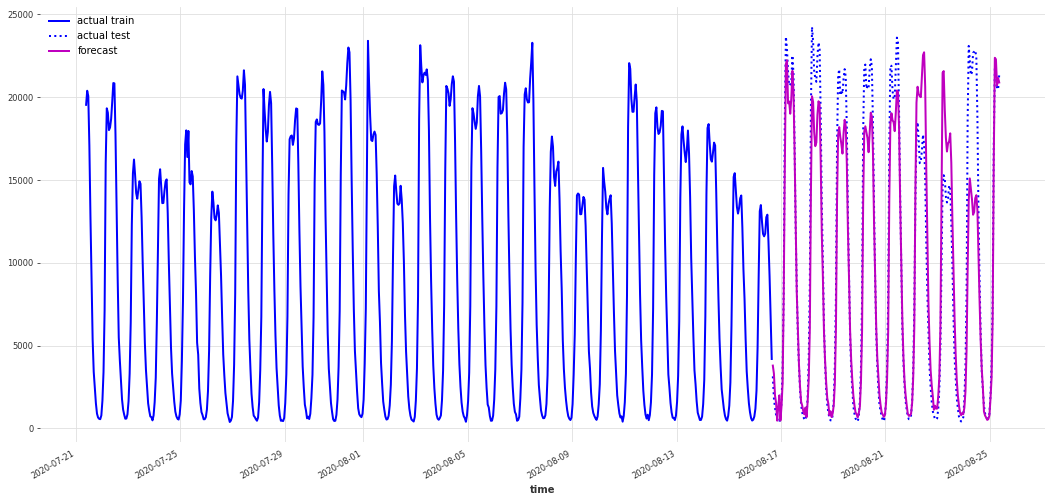

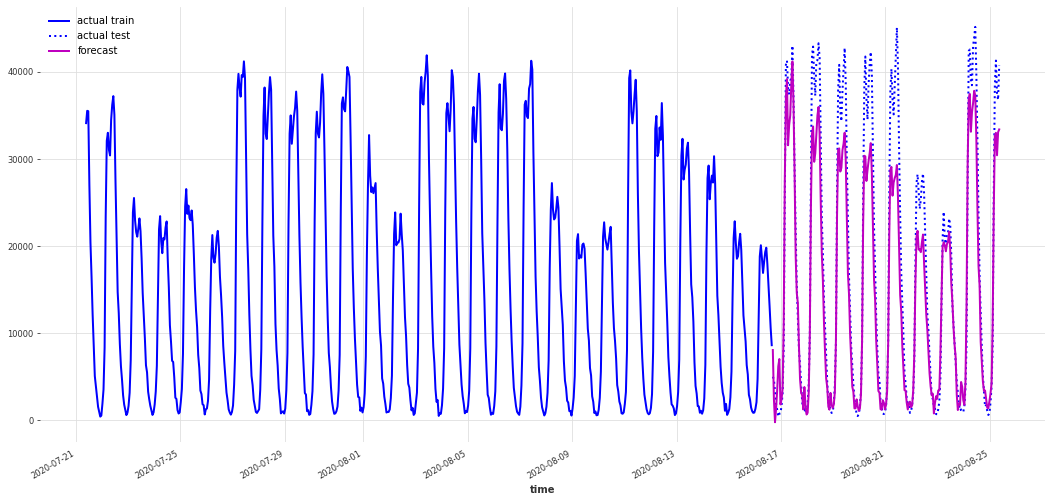

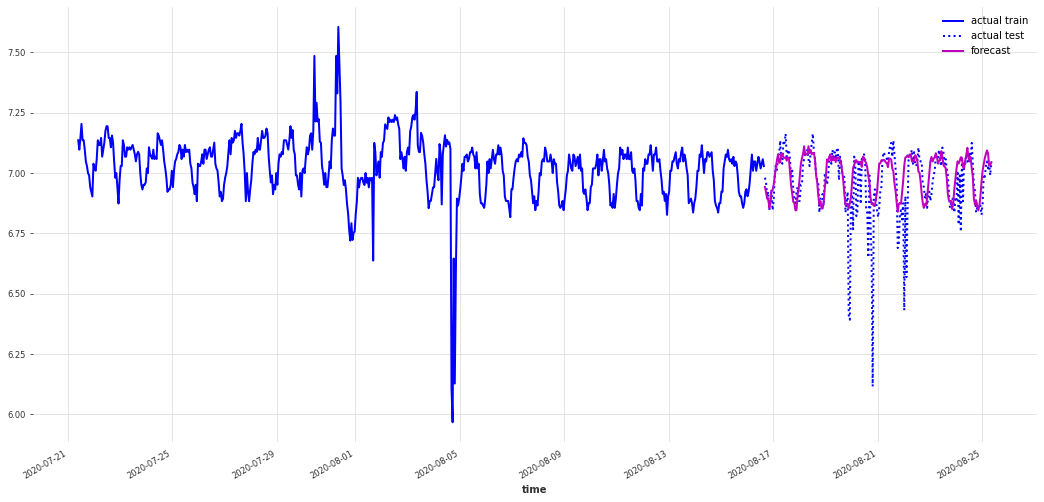

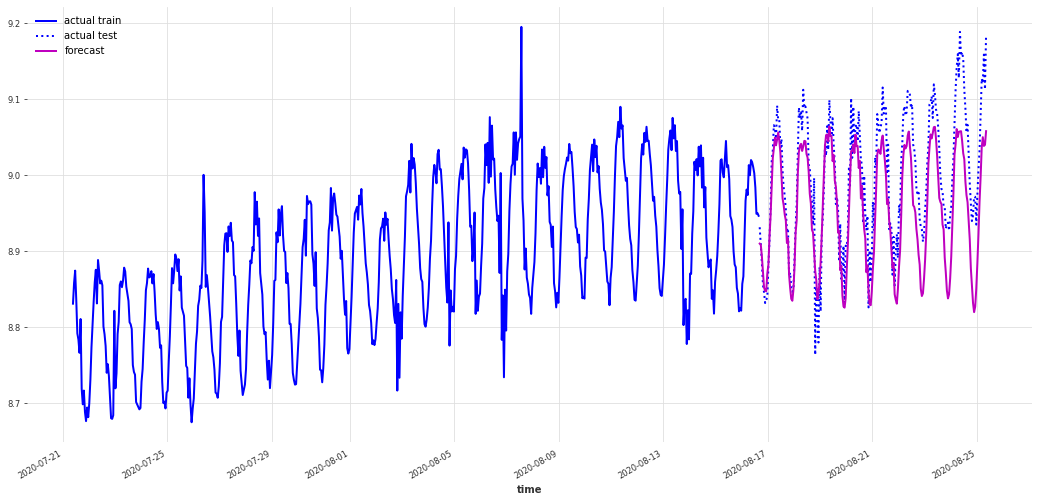

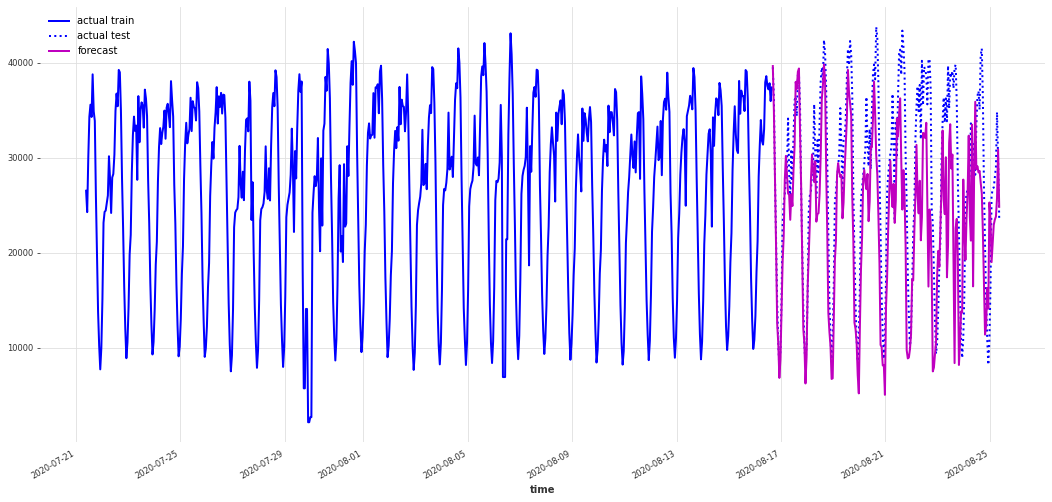

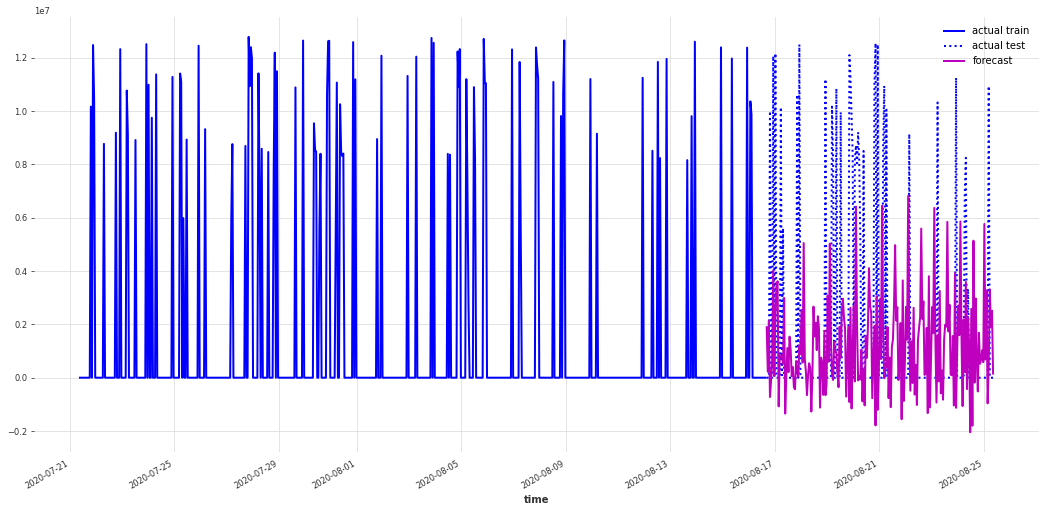

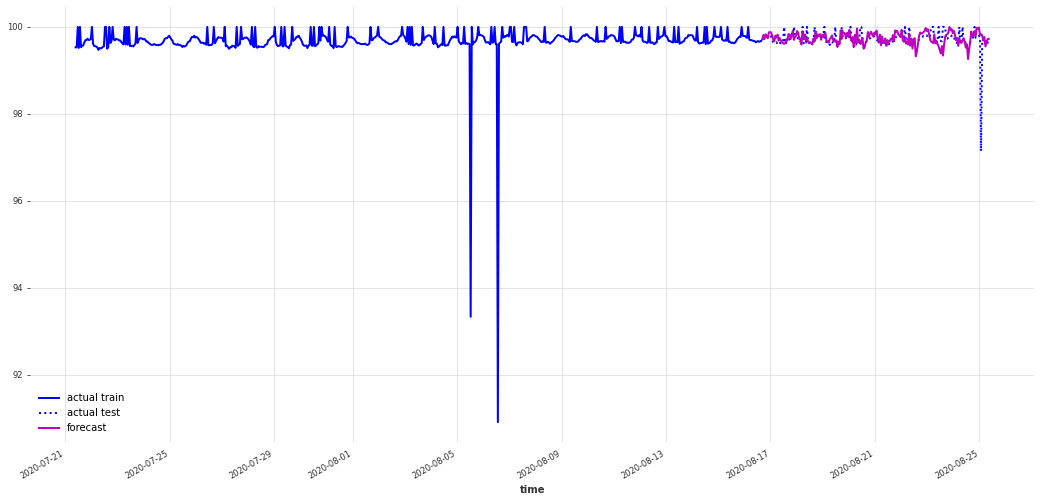

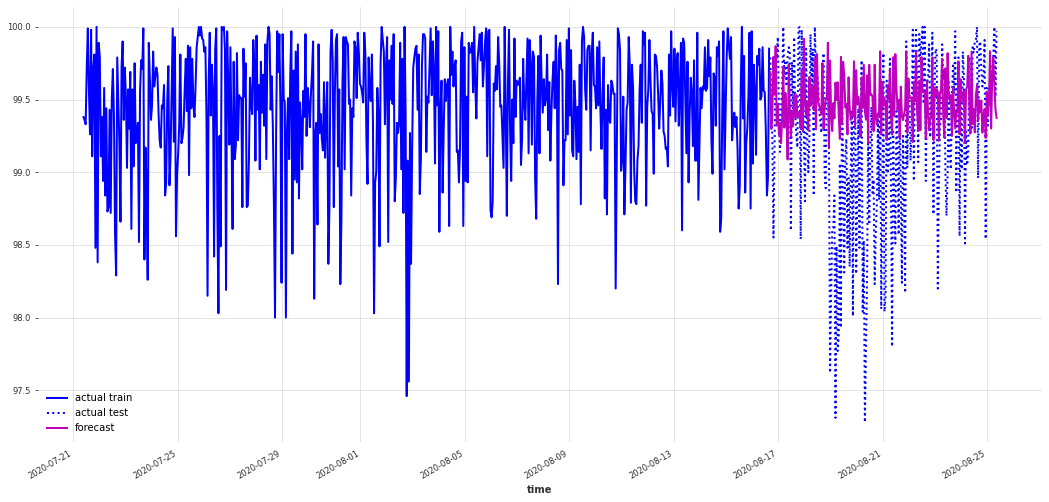

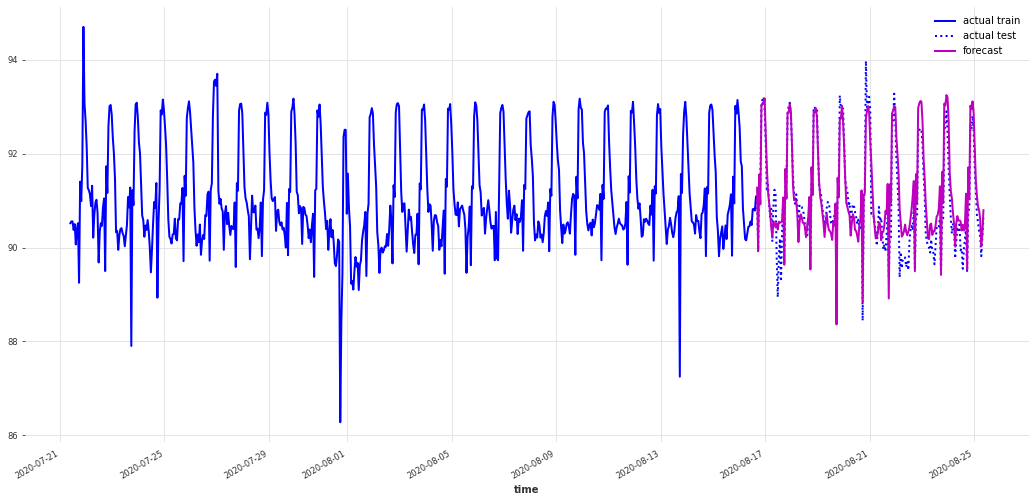

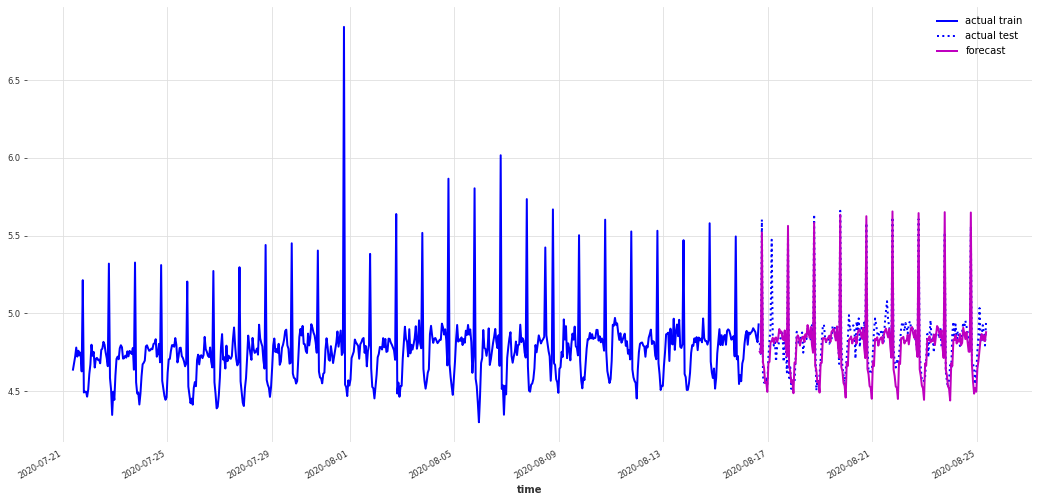

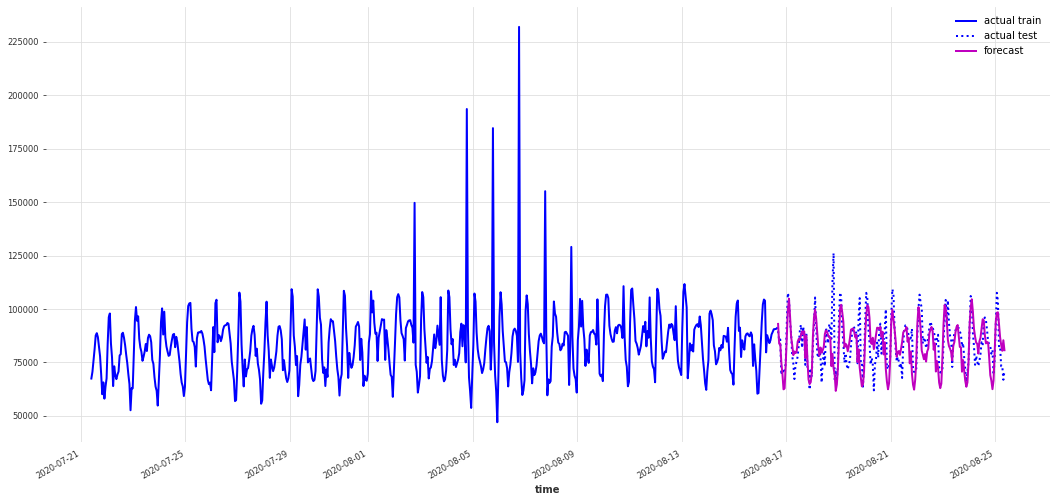

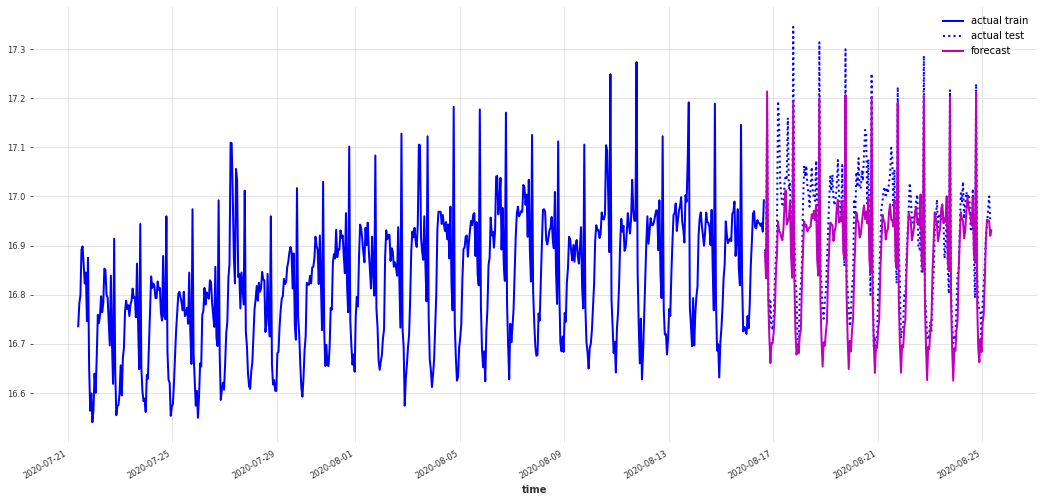

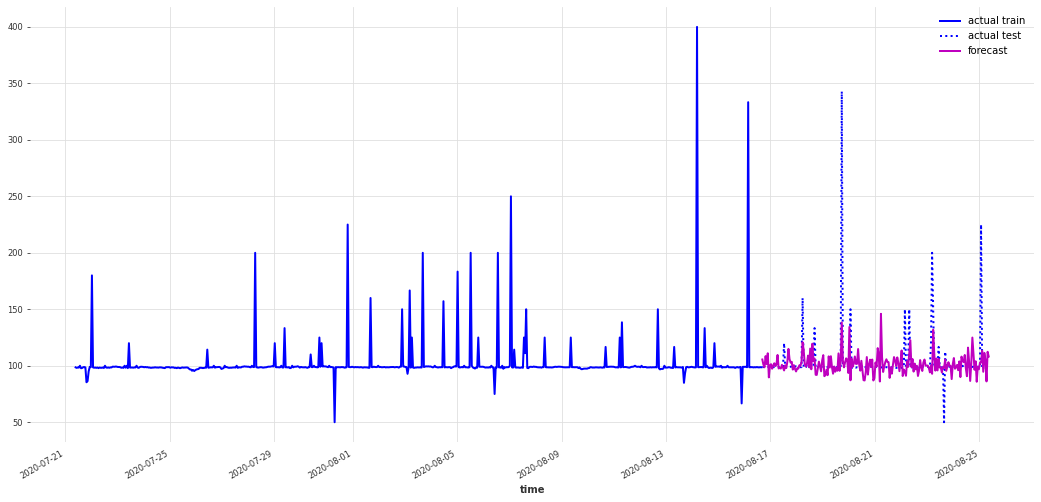

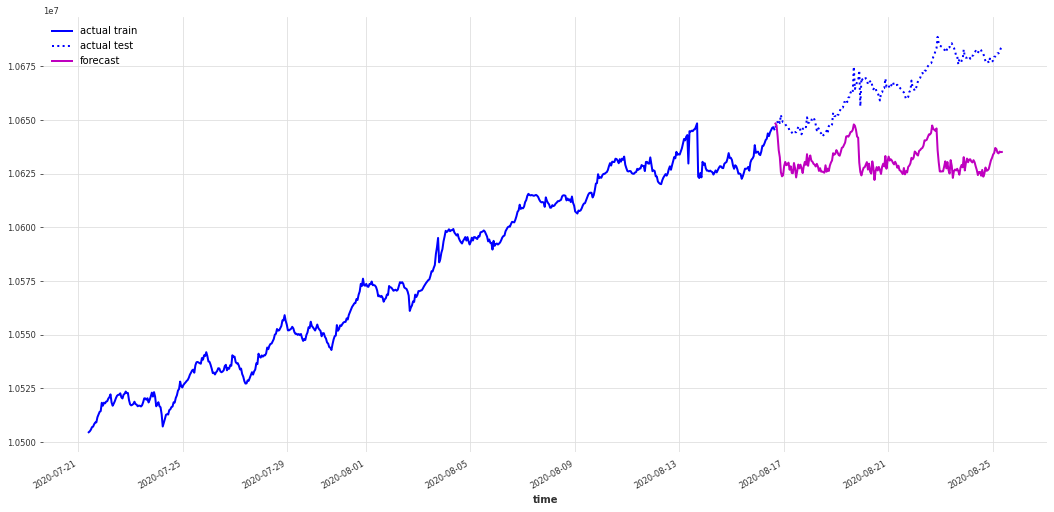

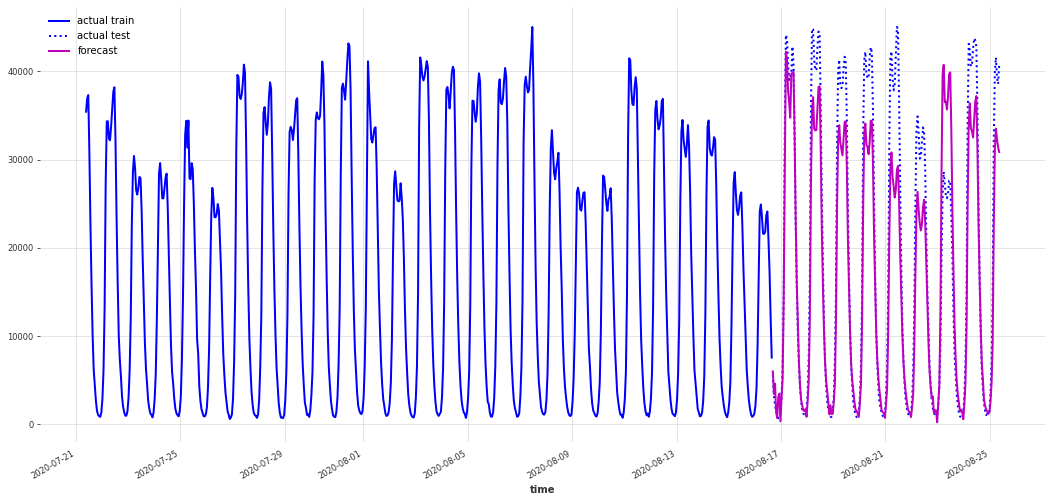

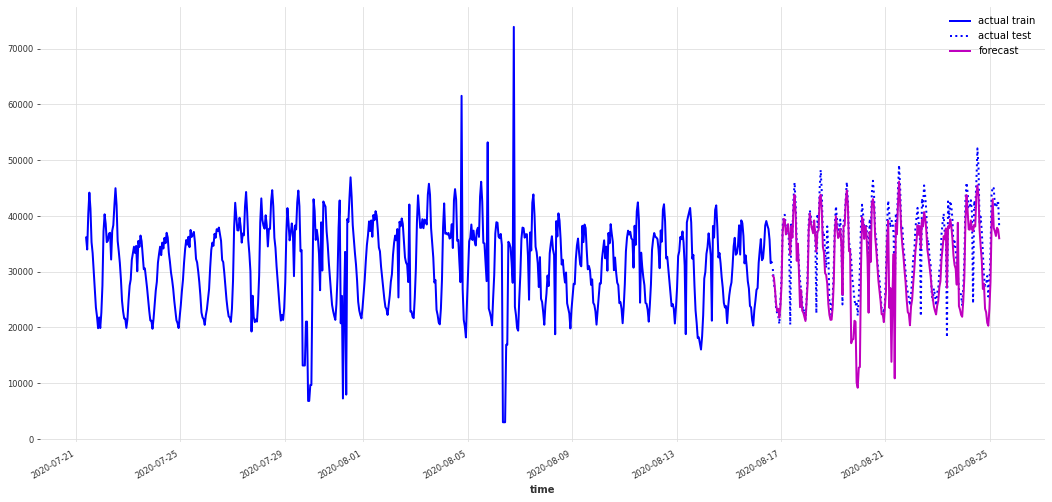

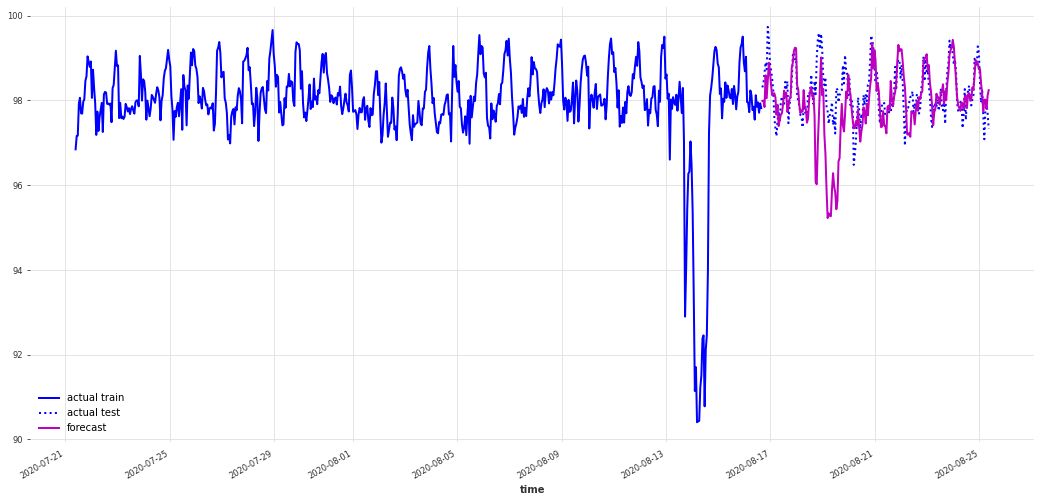

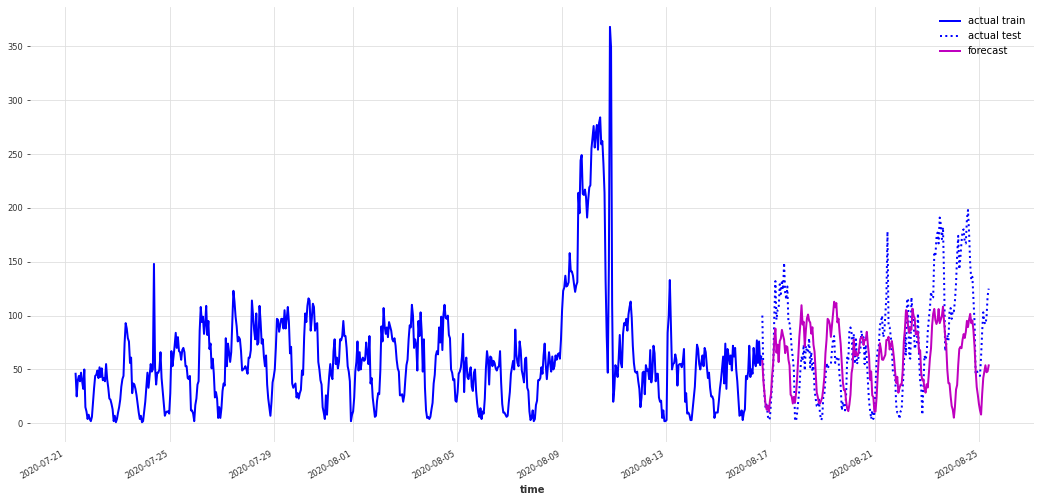

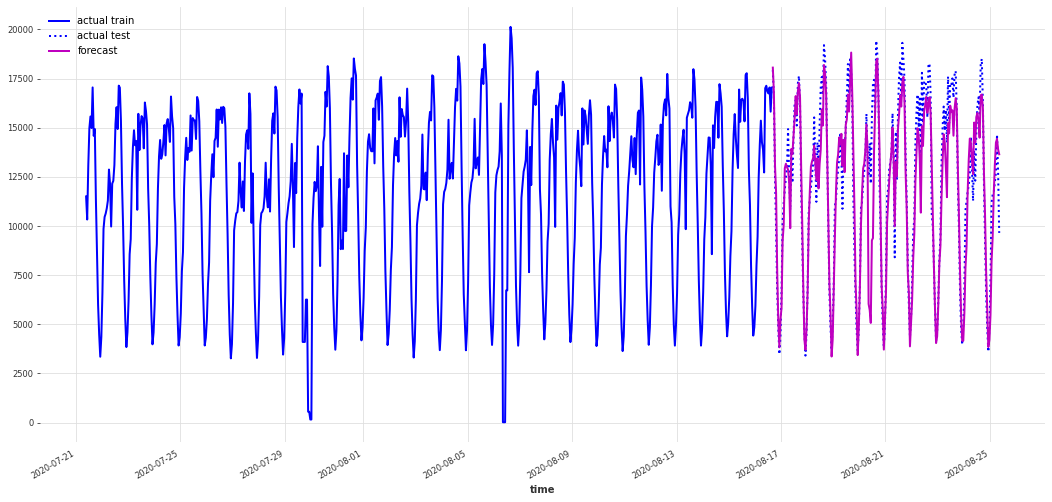

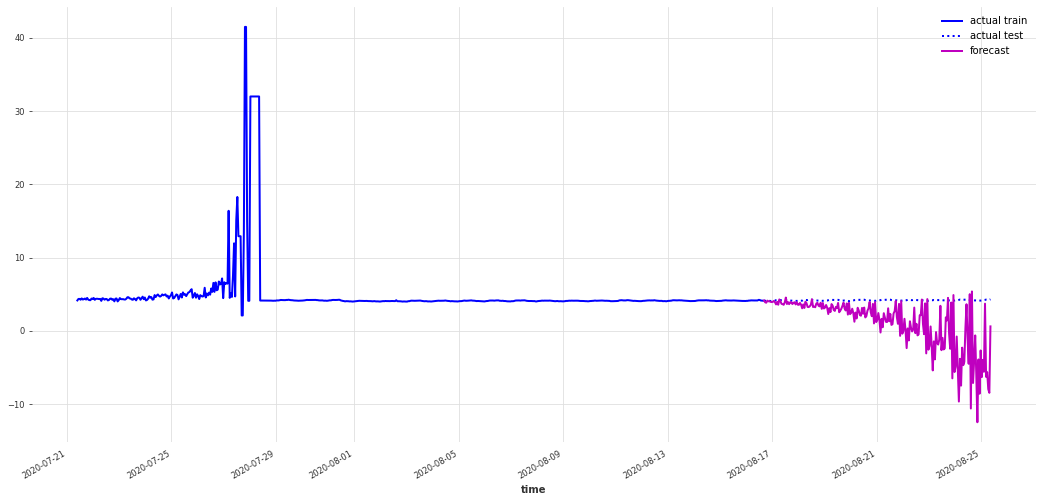

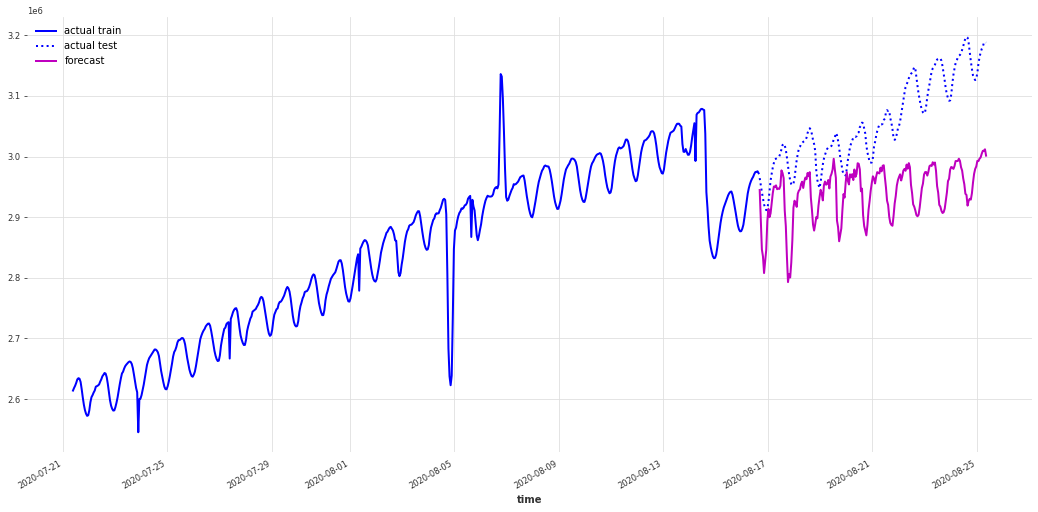

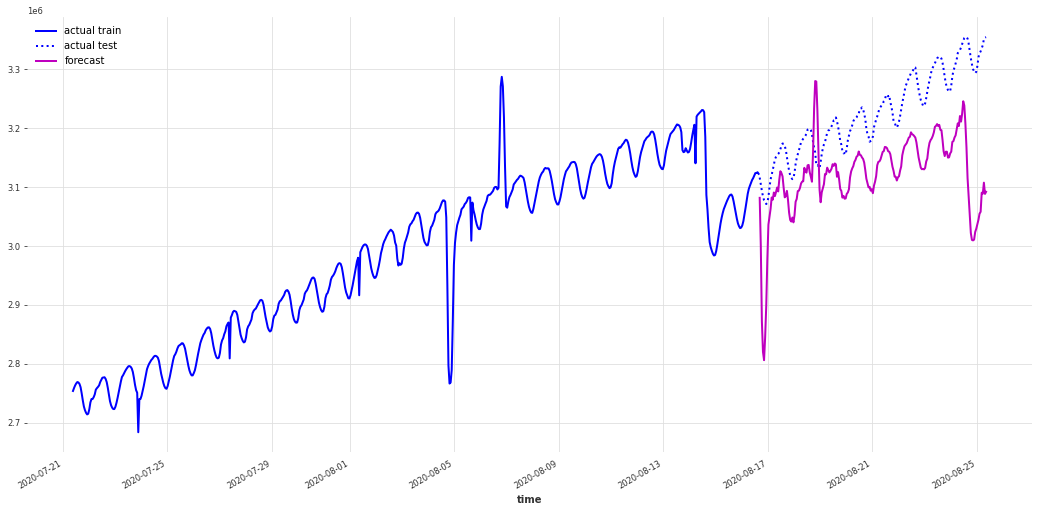

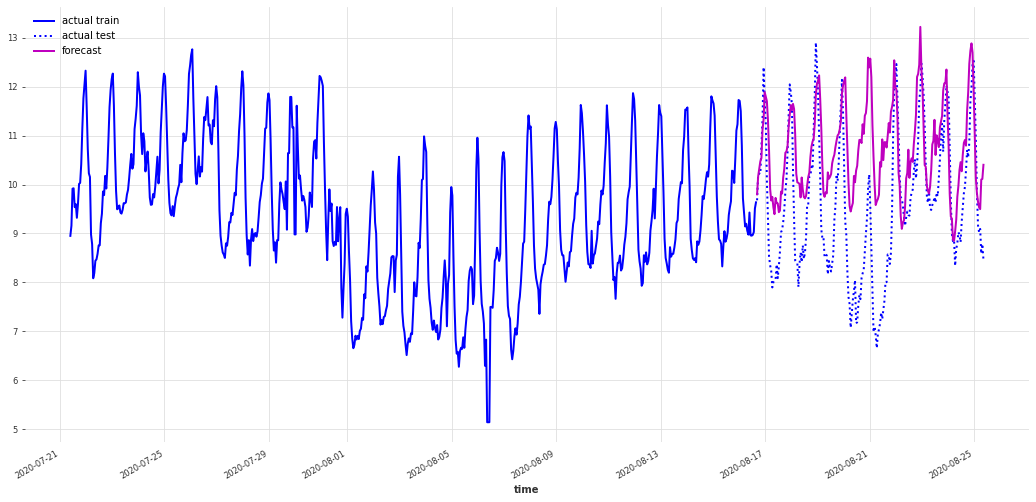

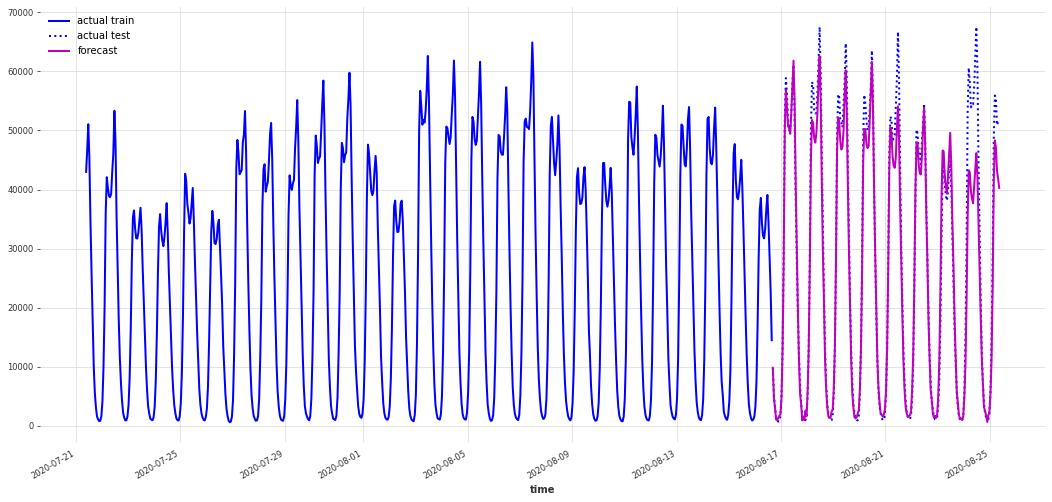

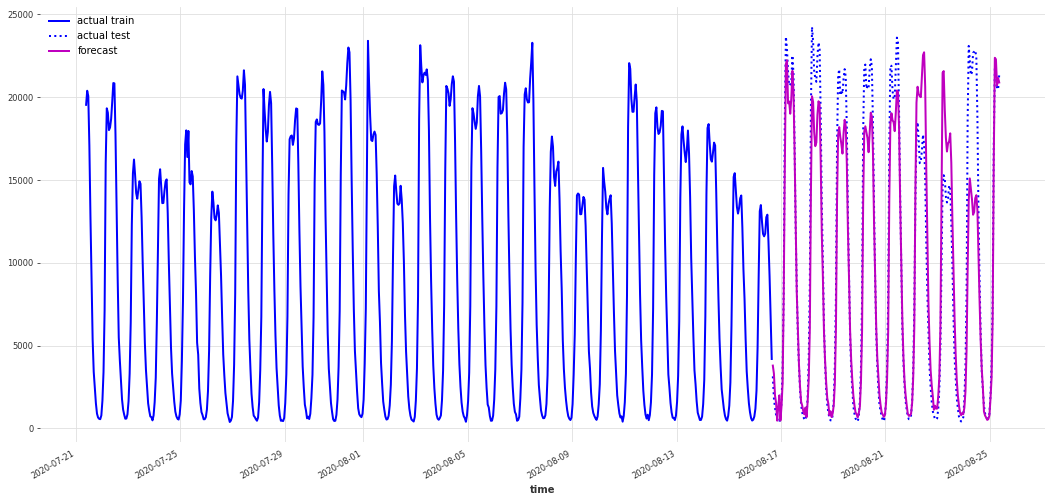

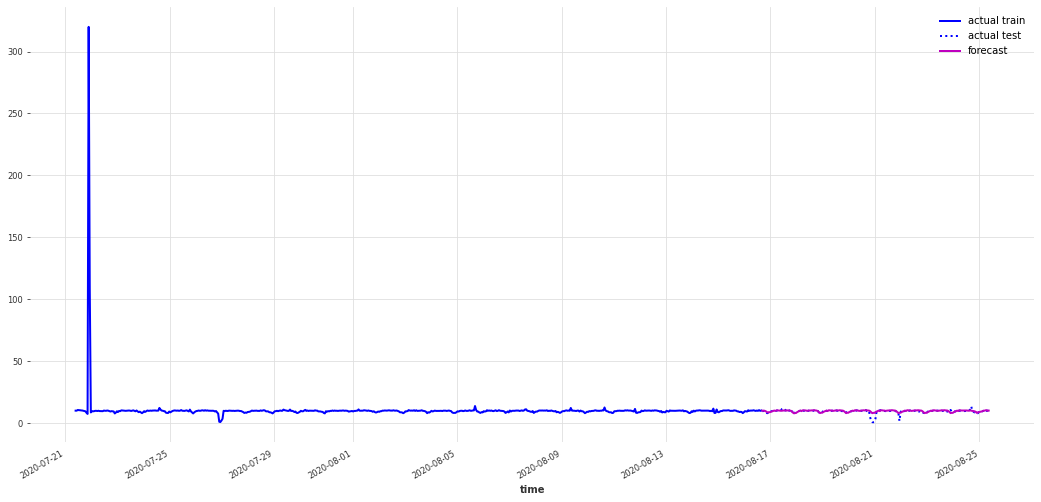

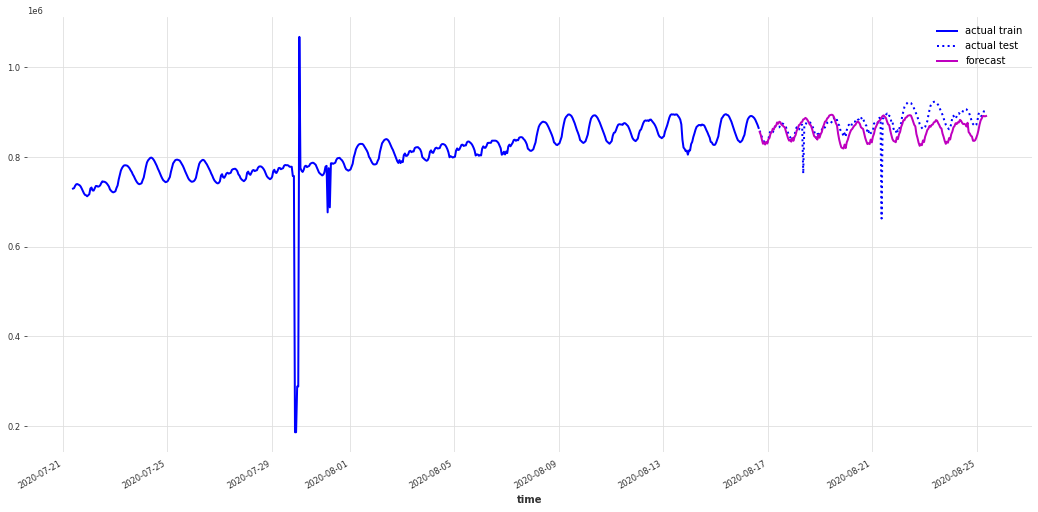

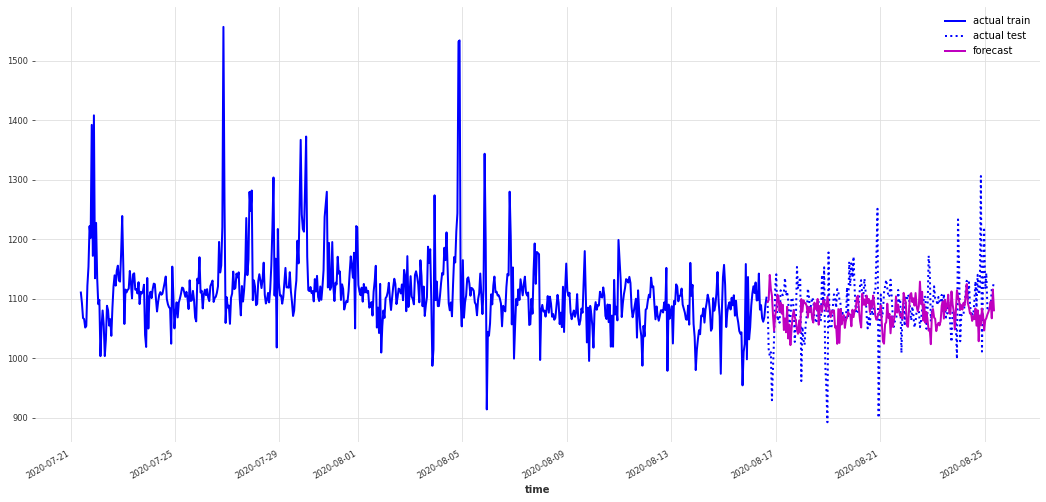

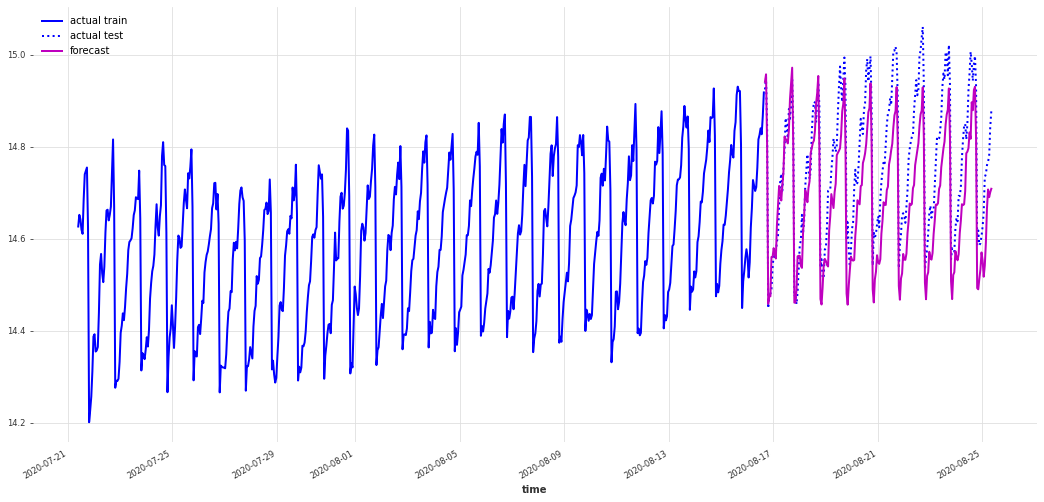

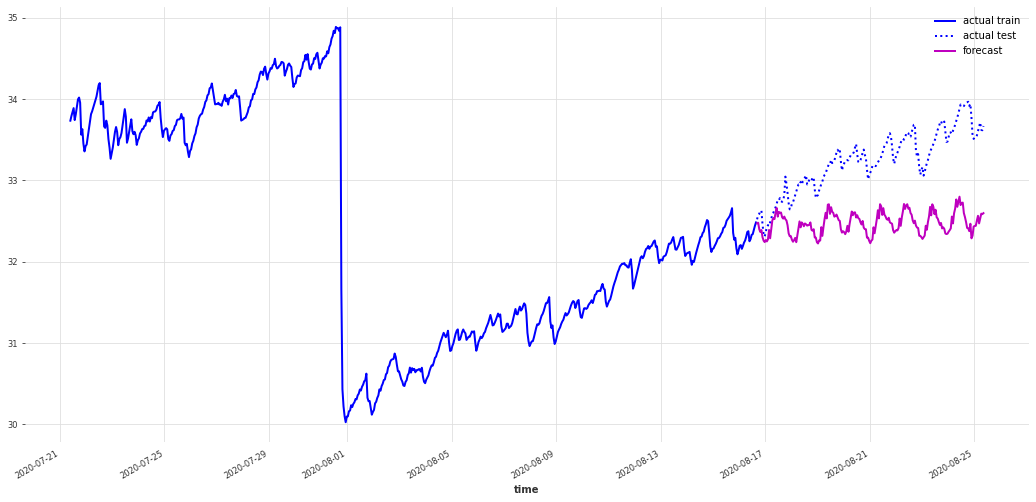

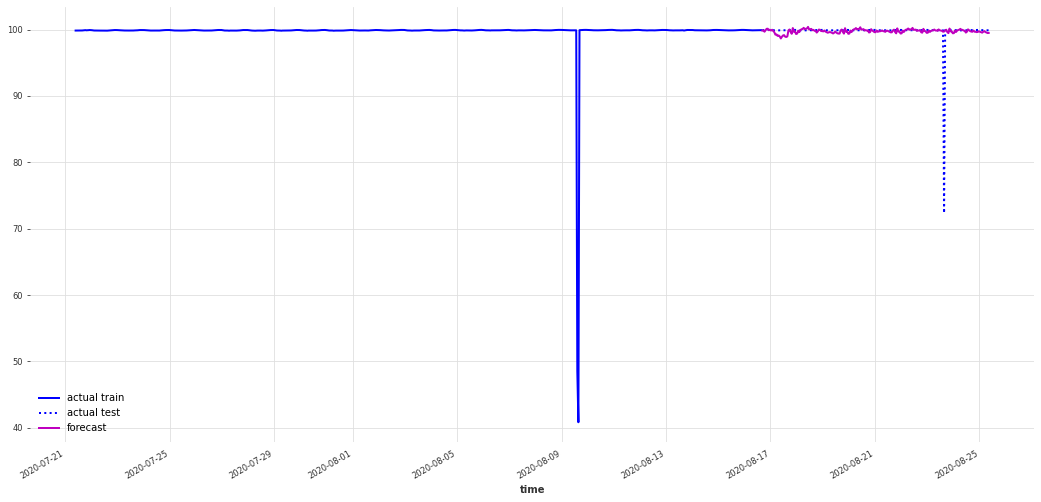

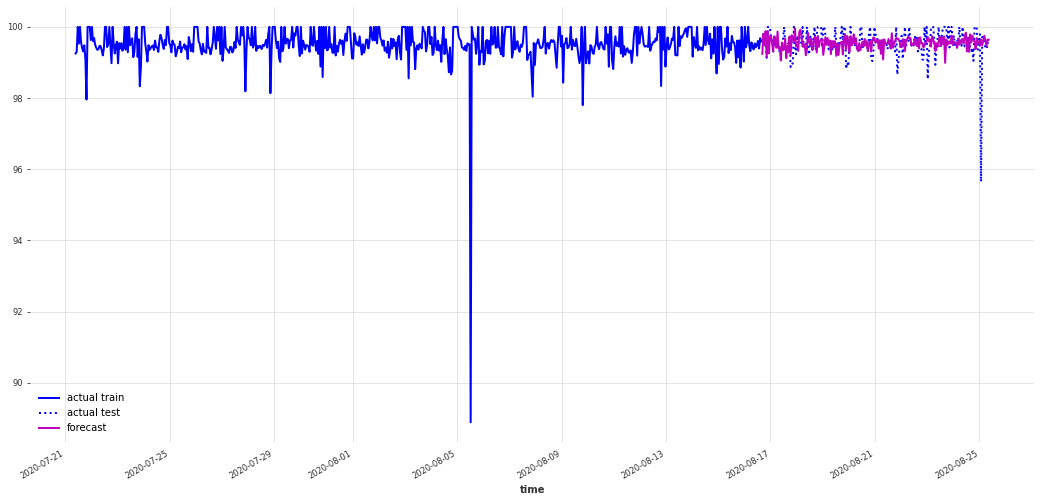

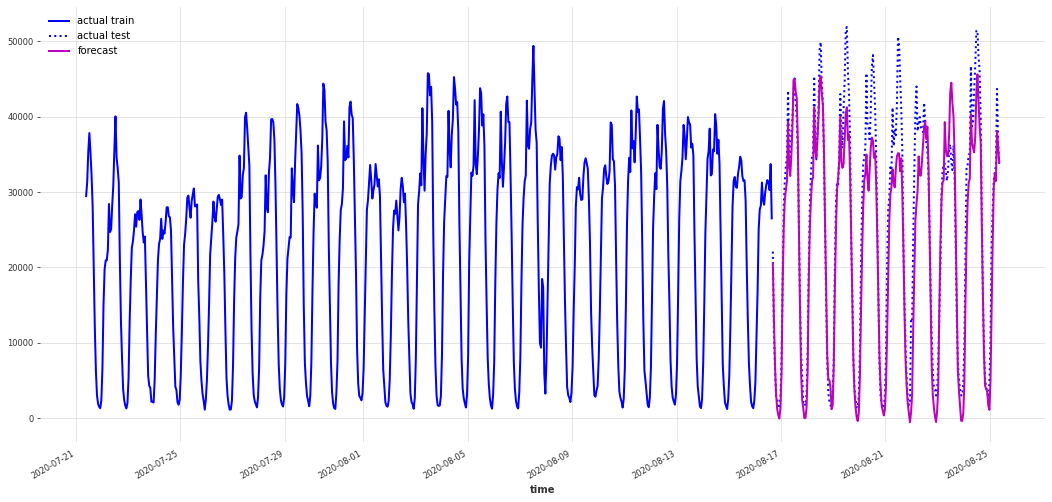

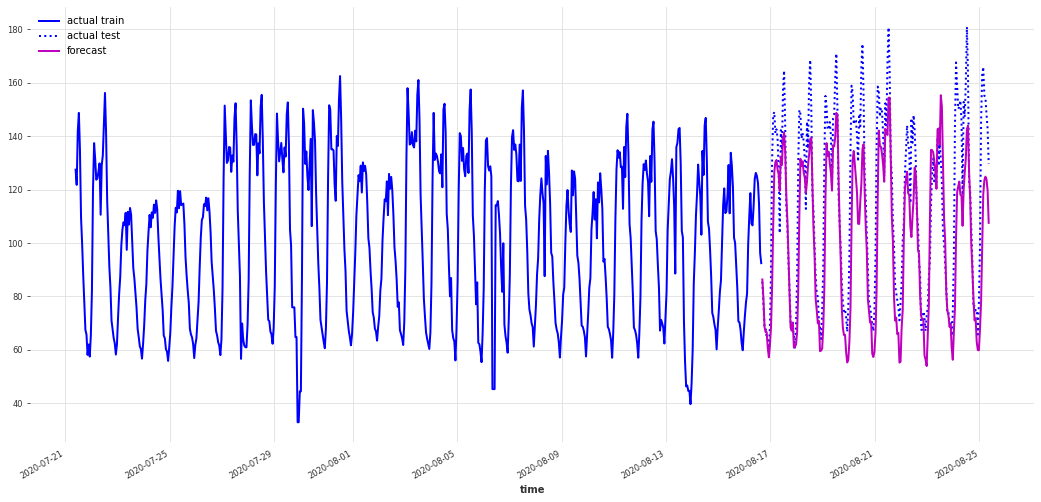

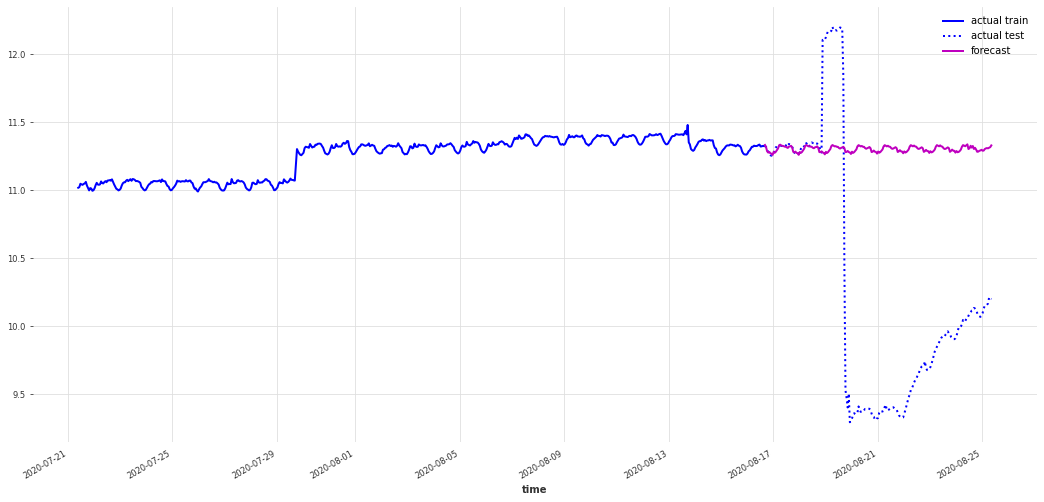

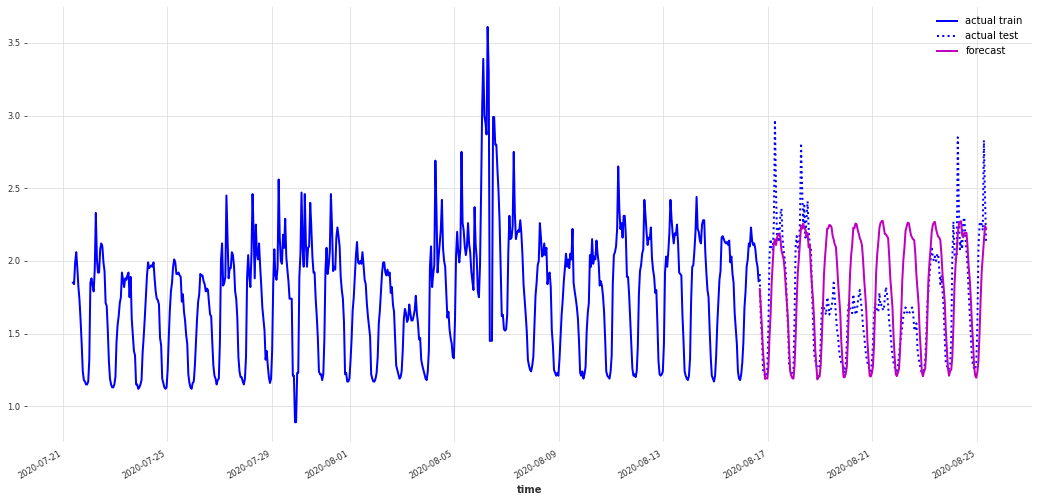

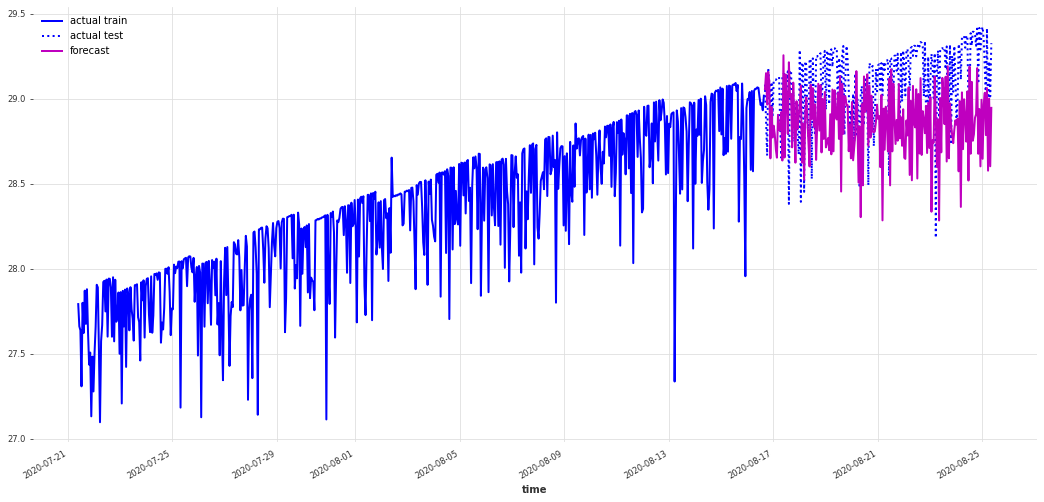

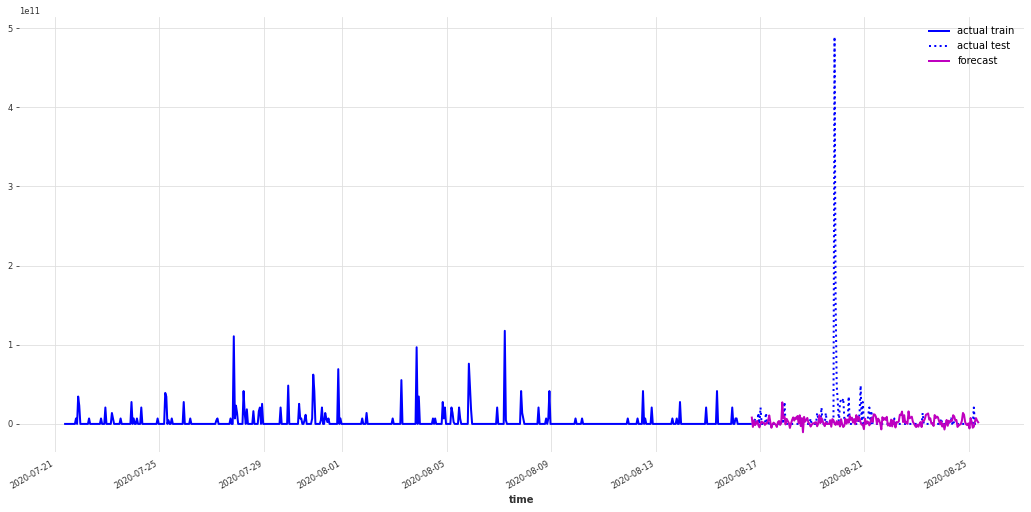

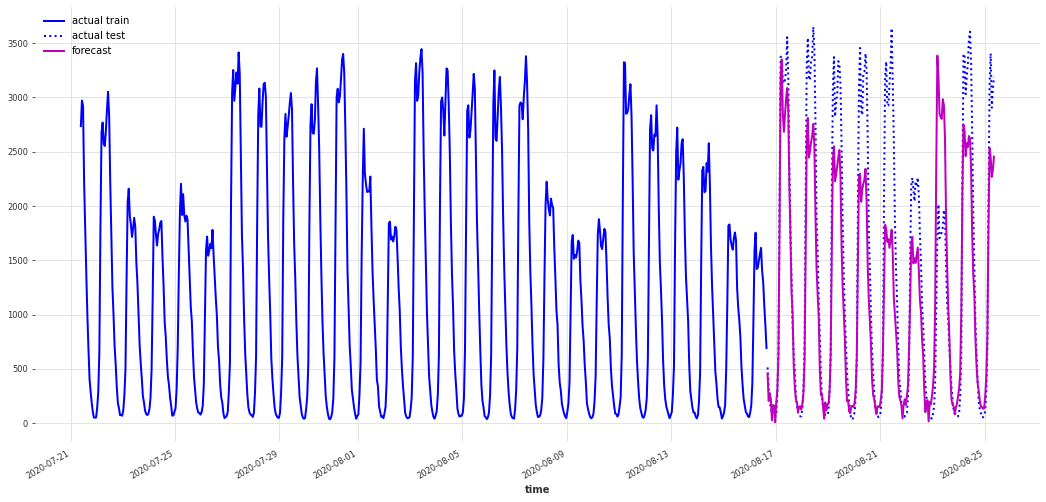

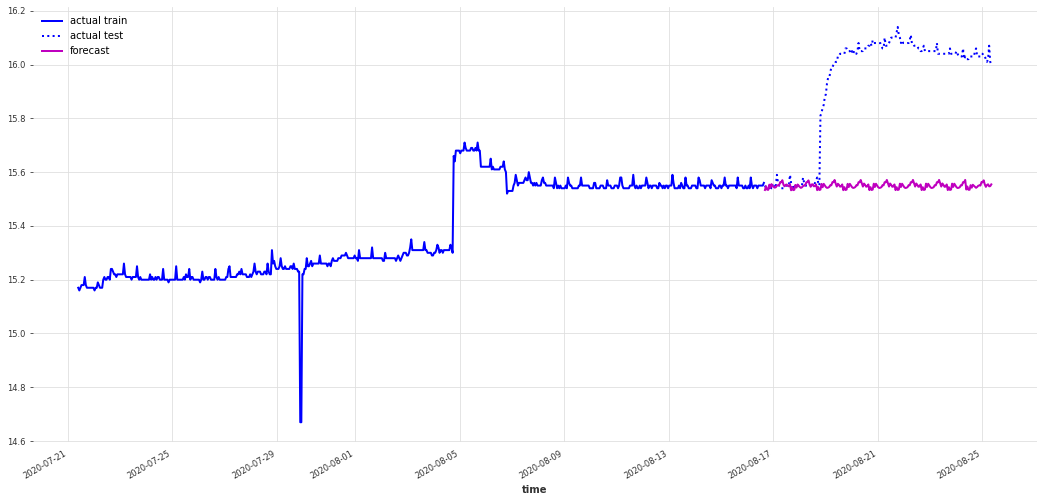

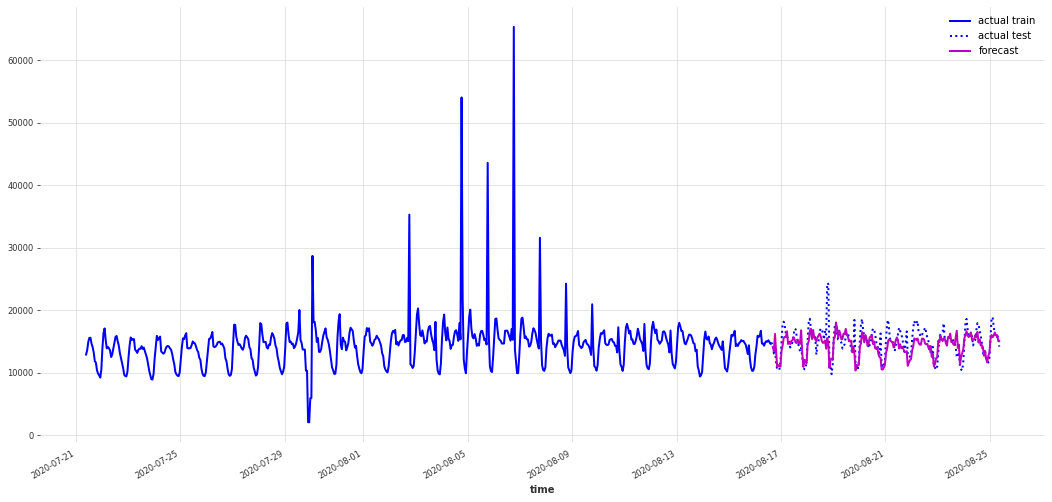

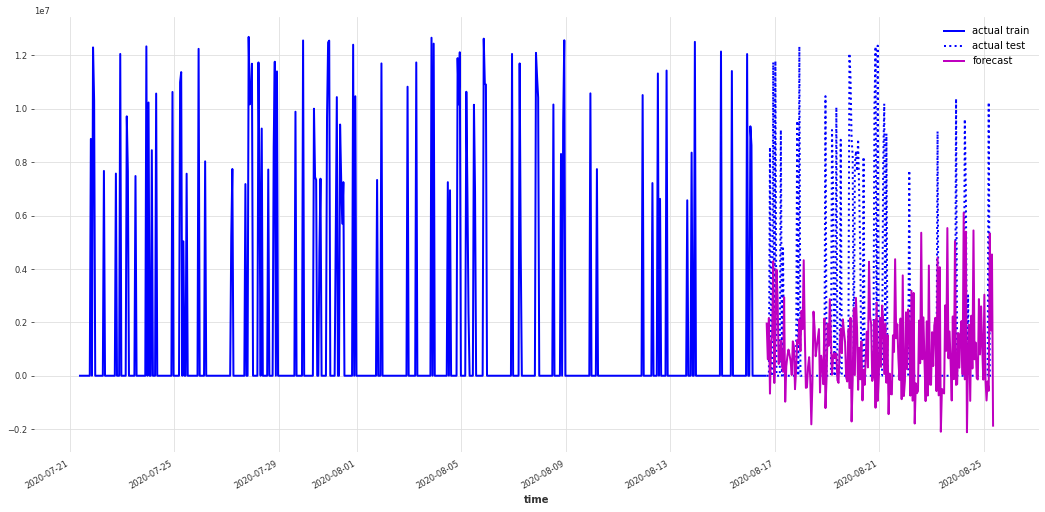

In [28]:
metrics=dict()

# path to save forecast pngs
FORECASTS_PATH = ASSIGNMENT_PATH + 'forecasts/'
    
for i in range(50):
    # print(str(i)+' iteration') 
    data = pd.read_csv(DATASET_PATH+str(i)+'.csv',index_col=0)
    data=preprocess(data)
    
    x,revin_layer = norm(data,column_name='value')
    
    num_samples=data.shape[0]
    c = int(num_samples*0.75)+1
    x_train, x_test = x[:c], x[c:]
    test_size = len(x_test)
    
    model = NBEATSModel(input_chunk_length=tsize, output_chunk_length=vsize, random_state=0, force_reset=True)
    model.fit(x_train, verbose=False)
    
    p = model.predict(n=test_size,series=x_train)
    
    x_train=denorm(x_train,revin_layer)
    x_test=denorm(x_test,revin_layer)
    p=denorm(p,revin_layer)
    
    # save metrics to a dictionary with iteration number as key
    metrics[i]=get_metrics(x_test,p)
    # plot forecast and save plot as png image to given path with forecast_i as name
    fig=plot_forecast(x_train,x_test,p)
    fig.savefig(FORECASTS_PATH+'forecast_'+str(i)+'.png')
    close(fig)
# convert metrics dictionary to dataframe and assign names to error metric columns
metrics = pd.DataFrame.from_dict(metrics, orient ='index') 
metrics.columns=['MAE','MSE','RMSE','MAPE']

In [29]:
# save metrics dataframe as csv in assignment folder
metrics.to_csv(ASSIGNMENT_PATH+'metrics.csv')
metrics

MAE           MSE          RMSE              MAPE
0   1.261251e-01  2.419830e-02  1.555580e-01          0.262903
1   6.555518e-02  1.038899e-02  1.019264e-01          0.229906
2   1.161702e+00  2.037466e+00  1.427398e+00          2.655545
3   7.048688e+01  6.553409e+03  8.095313e+01          2.032005
4   1.408474e-13  3.111569e-26  1.763964e-13              <NA>
5   3.039140e+00  2.088049e+01  4.569517e+00         72.603915
6   8.488952e+09  1.363663e+21  3.692781e+10  344756319.494681
7   1.406380e+02  3.577096e+04  1.891321e+02         10.179927
8   1.877589e+03  7.756570e+06  2.785062e+03         30.018729
9   3.542309e+03  2.428687e+07  4.928171e+03         47.777417
10  7.024171e-02  1.446793e-02  1.202827e-01          1.032094
11  4.774271e-02  3.323142e-03  5.764670e-02          0.529434
12  5.852873e+03  5.872289e+07  7.663086e+03          22.03833
13  2.886069e+06  1.877441e+13  4.332945e+06   38312716.134633
14  1.260038e-01  5.761957e-02  2.400408e-01          0.126626
15  4.891417e-01  4.376590e-01  6.615580e-01          0.495083
16  3.554838e-01  2.098316e-01  4.580738e-01          0.391613
17  7.098968e-02  9.550073e-03  9.772447e-02          1.463162
18  6.853633e+03  8.547810e+07  9.245437e+03          8.159491
19  5.952956e-02  5.224873e-03  7.228329e-02          0.351068
20  9.145266e+00  4.612809e+02  2.147745e+01          7.737347
21  3.388816e+04  1.350720e+09  3.675215e+04          0.317592
22  4.064237e+03  3.261009e+07  5.710525e+03         30.340762
23  3.514645e+03  2.572509e+07  5.071990e+03          10.95853
24  5.092880e-01  5.891497e-01  7.675609e-01          0.518668
25  3.565531e+01  1.981118e+03  4.450976e+01         81.834769
26  1.118068e+03  2.765489e+06  1.662976e+03          9.372476
27  3.039140e+00  2.088049e+01  4.569517e+00         72.603915
28  1.151465e+05  1.727907e+10  1.314499e+05          3.729322
29  1.065232e+05  1.492960e+10  1.221867e+05           3.28479
30  1.287856e+00  2.561985e+00  1.600620e+00         14.891567
31  2.928852e+03  2.480956e+07  4.980920e+03         17.277042
32  1.877589e+03  7.756570e+06  2.785062e+03         30.018729
33  6.087131e-01  1.796516e+00  1.340342e+00         22.738701
34  2.040411e+04  8.530290e+08  2.920666e+04          2.358118
35  4.220026e+01  3.408786e+03  5.838481e+01          3.890335
36  8.552588e-02  9.584040e-03  9.789811e-02          0.577966
37  7.638649e-01  6.980850e-01  8.355148e-01          2.287707
38  3.739558e-01  3.685734e+00  1.919827e+00          0.424246
39  2.812694e-01  1.894716e-01  4.352833e-01          0.283268
40  3.732916e+03  2.537649e+07  5.037509e+03         24.998846
41  1.579017e+01  4.538594e+02  2.130398e+01          12.89961
42  1.139101e+00  1.838258e+00  1.355824e+00         11.663681
43  2.517552e-01  1.048429e-01  3.237945e-01          14.53742
44  3.281028e-01  1.486312e-01  3.855271e-01          1.125914
45  9.540721e+09  1.352345e+21  3.677425e+10   35785906.639275
46  4.241708e+02  3.521282e+05  5.934039e+02         56.435302
47  3.760164e-01  1.862921e-01  4.316156e-01          2.343598
48  1.253690e+03  3.045105e+06  1.745023e+03          8.097194
49  2.595924e+06  1.592272e+13  3.990328e+06    5282933.921405